# Úkoly 
1. vykreslete grafy prvních 5 Legendrových polynomů na intervalu [-1,1]

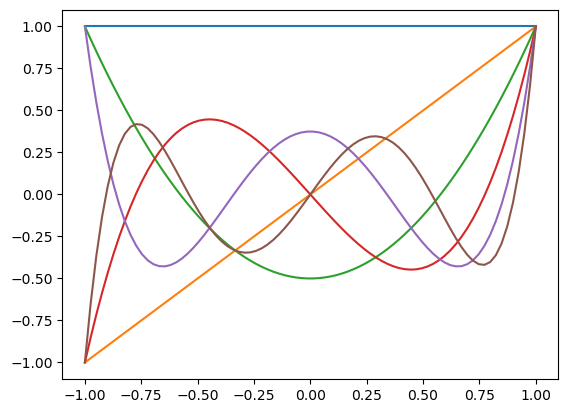

In [143]:
# pouziju tzv. bonnetuv rekurentni vzorec
import numpy as np
import matplotlib.pyplot as plt

def legendre(x, n):
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return ((2*n-1)*x*legendre(x,n-1) - (n-1)*legendre(x,n-2))/n

fig, ax = plt.subplots()
interval = np.linspace(start = -1, stop = 1, num = 80)
for i in range(6):
    ax.plot(interval, [legendre(x, i) for x in interval])

2. vyrobte sparse matici reprezentující čtvercovou síť o velikosti $n \times n$, kde každá buňka sítě odpovídá jednomu řádku/sloupci matice. V každém řádku/sloupci matice jsou nuly, kromě diagonálního prvku s hodnotou $1 + k \cdot \varepsilon$ (kde $k$ určuje počet sousedních buněk = 4 uvnitř, 3 na hranách, 2 v rozích) a prvků odpovídajícím sousedním buňkám (nahoře, dole, vlevo, vpravo) s hodnotou $-\varepsilon$. Pořadí buněk čtvrtcové sítě berte po řádcích. Sestavte matici pomocí formátu LIL a vyplňte hodnoty pomocí cyklu přes všechny buňky sítě.
    - tedy matice má velikost $n^2 \times n^2$
    - $\varepsilon$ je parametr, který můžete nastavit, například $\varepsilon = 0.1$
    - matice je symetrická, tj. $A = A^T$
    - každý řádek/sloupec má maximálně 5 nenulových prvků
        - 5, pokud se jedná o buňku unvitř sítě
        - 4, pokud se jedná o buňku na okraji sítě
        - 3, pokud se jedná o buňku v rohu sítě
    - výsledná matice je 5-ti diagonální

Pro $n=3$ a $\varepsilon = 0.1$ by měla matice (v plné formě) měla vypadat následovně:
```python
[[ 1.2 -0.1  0.  -0.1  0.   0.   0.   0.   0. ]
 [-0.1  1.3 -0.1  0.  -0.1  0.   0.   0.   0. ]
 [ 0.  -0.1  1.2  0.   0.  -0.1  0.   0.   0. ]
 [-0.1  0.   0.   1.3 -0.1  0.  -0.1  0.   0. ]
 [ 0.  -0.1  0.  -0.1  1.4 -0.1  0.  -0.1  0. ]
 [ 0.   0.  -0.1  0.  -0.1  1.3  0.   0.  -0.1]
 [ 0.   0.   0.  -0.1  0.   0.   1.2 -0.1  0. ]
 [ 0.   0.   0.   0.  -0.1  0.  -0.1  1.3 -0.1]
 [ 0.   0.   0.   0.   0.  -0.1  0.  -0.1  1.2]]
 ```


In [146]:
import scipy.sparse as sparse
n = 3
eps = 1e-1
A = sparse.lil_matrix((n*n, n*n))

for i in range(n):
    for j in range(n):
        B = np.zeros((n,n))
        
        if i != 0 and i != n-1 and j != 0 and j != n-1:
            k = 4 # prvky, ktere jsou uvnitr matice
        elif (i == 0 or i == n-1) and (j == 0 or j == n-1):
            k = 2 # prvky na rozich matice
        else:
            k = 3 # prvky co nejsou na rozich ani vevnitr => jsou na hranach
            
        B[i,j] = 1+k*eps
        if j > 0:
            B[i,j-1] = -eps # vlevo
        if j < n-1:
            B[i,j+1] = -eps # vpravo
        if i > 0:
            B[i-1,j] = -eps # nahore
        if i < n-1:
            B[i+1,j] = -eps # dole

        row = B.reshape((1,n**2))
        A[i*n+j,:] = row # prepis do souradnic 1d pole, budeme mit n^2 krat n^2 dlouhe pole, ktere je prepisem matice B do 1d pole
        

A.todense()

matrix([[ 1.2, -0.1,  0. , -0.1,  0. ,  0. ,  0. ,  0. ,  0. ],
        [-0.1,  1.3, -0.1,  0. , -0.1,  0. ,  0. ,  0. ,  0. ],
        [ 0. , -0.1,  1.2,  0. ,  0. , -0.1,  0. ,  0. ,  0. ],
        [-0.1,  0. ,  0. ,  1.3, -0.1,  0. , -0.1,  0. ,  0. ],
        [ 0. , -0.1,  0. , -0.1,  1.4, -0.1,  0. , -0.1,  0. ],
        [ 0. ,  0. , -0.1,  0. , -0.1,  1.3,  0. ,  0. , -0.1],
        [ 0. ,  0. ,  0. , -0.1,  0. ,  0. ,  1.2, -0.1,  0. ],
        [ 0. ,  0. ,  0. ,  0. , -0.1,  0. , -0.1,  1.3, -0.1],
        [ 0. ,  0. ,  0. ,  0. ,  0. , -0.1,  0. , -0.1,  1.2]])

3. sestavte matici $A$ z předchozího úkolu pomocí indexů řádků, sloupců a hodnot ve formátu CSR. 
    - Tedy sestavte tři pole: `row`, `col` a `data`, které obsahují řádky, sloupce a hodnoty nenulových prvků matice 
        - separátně sestavte příspěvky které vzniknou konektivitou na vnitřních horizontálních hranách a na vnitřních vertikálních hranách.
            - při procházení všech vnitřních horizontálních hran si rozmyslete jaké jsou vždy indexy nad a pod hranou (toto jsou souřadnice řádků a sloupců)
            - totéž pro vnitřní vertikální hrany zde se může hodit `np.arange(n * n).reshape((n, n)).T.flatten()` což vytvoří vektor s přeházenými indexy
        - zvlášť sestavte příspevky pro mimodiagonální prvky a diagonální prvky.
            - u diagonálních prvků, nejprve vyrobte vektor hodnot $1+ 4\cdot \varepsilon$ a pak pro každou hranu odečtěte $\varepsilon$.
    - Tyto pole vytvořte vektorizovaně - bez cyklů
    - Využíjte vlastnosti, že hodnoty se stejnými indexy se při sestavení sečtou.

In [147]:
# create matrix A using vectorized operations, creating indices for rows and columns and data
# use sparse.coo_matrix((data, (i, j)), shape=(n, n))
import numpy as np
from scipy.sparse import csr_matrix

n = 3
epsilon = 0.1

def A_efficiently(n, epsilon):
    diag = lambda x: np.diagflat(np.ones(n**2-np.abs(x))*epsilon, x)
    non_diag = np.zeros((n**2,n**2)) - diag(1) - diag(-1) - diag(3) - diag(-3)
    row_non_diag, col_non_diag = np.where(non_diag != 0)    
    data_non_diag = -epsilon * np.ones(row_non_diag.size)

    horizontal_up_idx = np.append(np.ones(n), np.zeros(n**2-n))
    horizontal_low_idx = np.append(np.zeros(n**2 - n), np.ones(n))
    vertical_left_idx = np.append(np.ones(n), np.zeros(n**2-n)).reshape(n,n).T.flatten()
    vertical_right_idx = np.append(np.zeros(n**2 - n), np.ones(n)).reshape(n,n).T.flatten()
    data = -epsilon * np.ones(n * n)

    ## --- Diagonála (všechny prvky)
    diagonal_idx = np.arange(n * n)
    row_diag = diagonal_idx
    col_diag = diagonal_idx
    data_diag = (1 + 4 * epsilon) * np.ones(n * n)

    # odečteme epsilon pro každou z hran
    # horní hrana
    data_diag[horizontal_up_idx == True] += data[horizontal_up_idx == True]
    # dolní hrana
    data_diag[horizontal_low_idx == True] += data[horizontal_low_idx == True]
    # levá hrana
    data_diag[vertical_left_idx == True] += data[vertical_left_idx == True]
    # pravá hrana
    data_diag[vertical_right_idx == True] += data[vertical_right_idx == True]

    ## --- spojení všech vektorů a sestavení matice
    # spojíme všechny vnitřní hrany a diagonálu
    row_idx_diag = np.hstack((row_diag, row_non_diag))
    col_idx_diag = np.hstack((col_diag, col_non_diag))
    data = np.hstack((data_diag, data_non_diag))

    # vyrobíme matici
    A_efficiently = csr_matrix((data, (row_idx_diag, col_idx_diag)), shape=(n**2, n**2)) # TODO - vytvořte matici v CSR formátu z dat, řádků a sloupců

    return A_efficiently

print(A_efficiently(n, epsilon).todense())

[[ 1.2 -0.1  0.  -0.1  0.   0.   0.   0.   0. ]
 [-0.1  1.3 -0.1  0.  -0.1  0.   0.   0.   0. ]
 [ 0.  -0.1  1.2 -0.1  0.  -0.1  0.   0.   0. ]
 [-0.1  0.  -0.1  1.3 -0.1  0.  -0.1  0.   0. ]
 [ 0.  -0.1  0.  -0.1  1.4 -0.1  0.  -0.1  0. ]
 [ 0.   0.  -0.1  0.  -0.1  1.3 -0.1  0.  -0.1]
 [ 0.   0.   0.  -0.1  0.  -0.1  1.2 -0.1  0. ]
 [ 0.   0.   0.   0.  -0.1  0.  -0.1  1.3 -0.1]
 [ 0.   0.   0.   0.   0.  -0.1  0.  -0.1  1.2]]


4. Použijte matici $A$ z předchozích úkolů. Vytvořte (použijte níže vytvořený) vektor $b$ odpovídající čtvercové síti s nulami všude kromě malého čtverce uprostřed ($n/6$ okolo středu) s hodnotou 1. 
    - Vykreslete řešení $x$ systému $A \cdot x = b$ jako obrázek čtvercové sítě
    - Spočtěte a vizualizujte 3 vlastní vektory matice $A$ (vlastní vektory odpovídající největším vlastním hodnotám) - opět jako obrázek čtvercové sítě

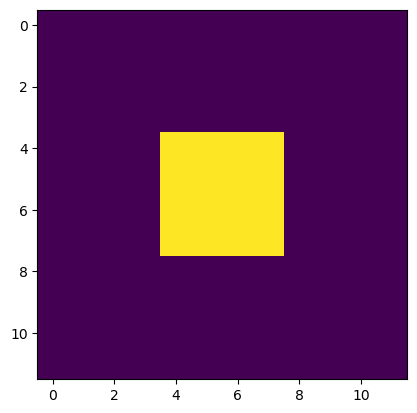

In [148]:
import matplotlib.pyplot as plt

n = 12
epsilon = 2e-1
A = A_efficiently(n, epsilon)

b = np.zeros((n, n))
b[n//2 - n//6:n//2 + n//6,n//2 - n//6:n//2 + n//6] = 1
b = b.flatten()
plt.imshow(b.reshape((n, n)))

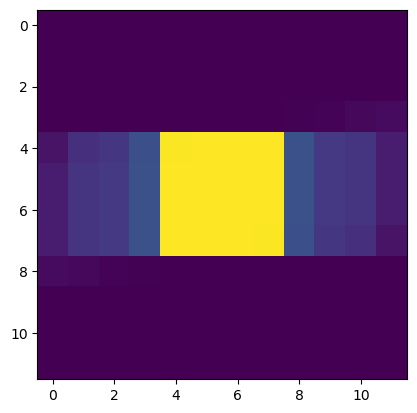

In [149]:
import scipy as sp

# TODO - vyřešte lineární rovnici A x = b a vykreselete výsledek
x = sp.sparse.linalg.spsolve(A,b)
plt.imshow(x.reshape(n,n))

C:\Users\pepaz\AppData\Local\Temp\ipykernel_20516\4216439134.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  evect = evect.reshape(n,n).astype("float")


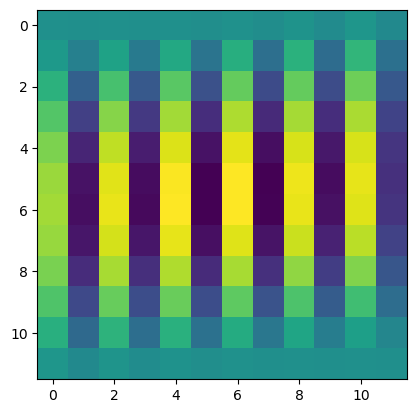

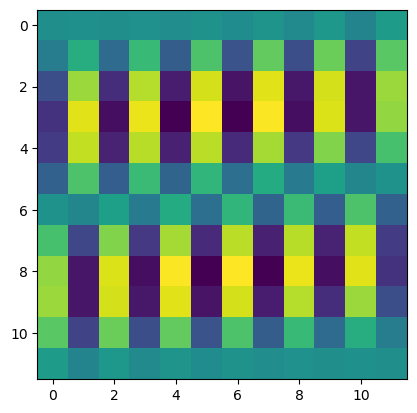

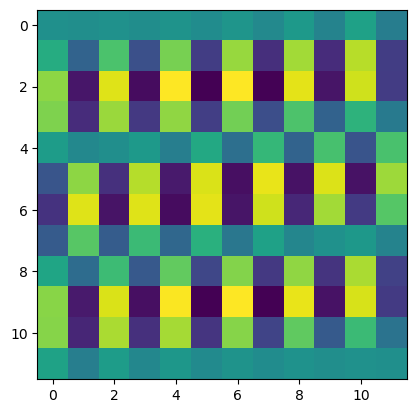

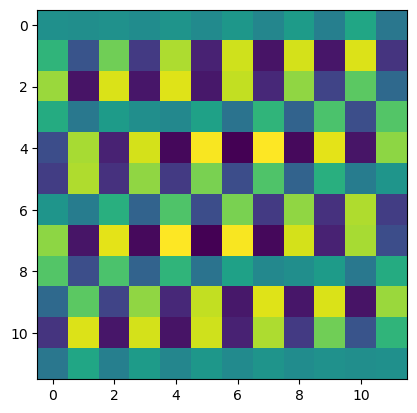

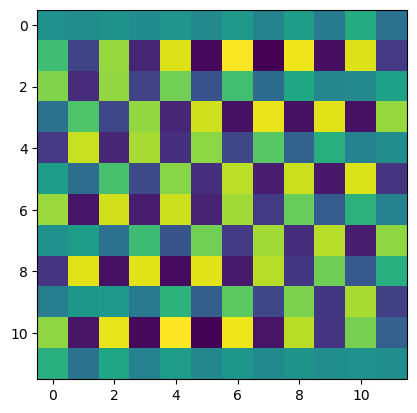

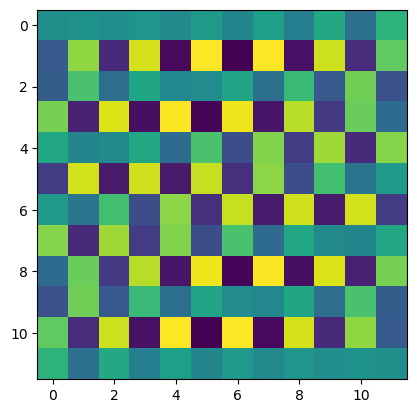

In [150]:
# TODO - spočtěte a vykreslete vlastní vektory matice A
evectors = sp.sparse.linalg.eigs(A)[1]
for i in range(6):
    evect = evectors[:,i]
    evect = evect.reshape(n,n).astype("float")
    plt.figure()
    plt.imshow(evect)


5. Nalezněte všechny kořeny Legendrova polynomu stupně 5 na intervalu $<-1,1>$

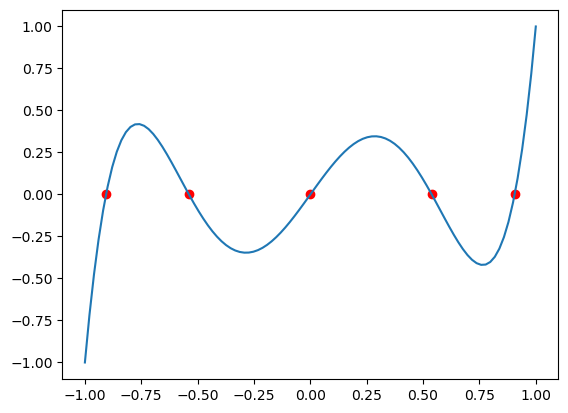

In [151]:
# poznamka - kdybych postupoval rucne musel bych hledat intervaly, kde se meni znamenka a pote hledat jednotlive koreny pomoci standartnich numerickych metod jako treba riddersova nebo newtonova

import numpy as np
degree = 5
polynomial = np.polynomial.legendre.Legendre([0]*degree + [1])
roots = polynomial.roots()

fig, ax = plt.subplots()
interval = np.linspace(start=-1,stop=1,num=100)
ax.plot(interval, [polynomial(i) for i in interval])
ax.scatter(roots, [polynomial(i) for i in roots], color="red");

6. Pomocí SymPy nalezněte všechny kořeny Legendrova polynomu stupně 5. Použíjte `sympy.legendre()` pro vytvoření výrazu odpovídajícímu Legendrovu polynomu.
- porovnejte výsledky s předchozím úkolem

In [152]:
import sympy as sp
from math import sqrt

x = sp.Symbol('x')
legendre_ = sp.legendre(5, x)

sp_koreny = [float(i) for i in list(sp.roots(legendre_))]
sp_koreny = np.sort(np.array(sp_koreny))
roots = np.sort(roots)
rozdil = np.linalg.norm(sp_koreny - roots)
print(rozdil)

1.1273312171982056e-15
